# 클린업 2주차 - Word2Vec for Korean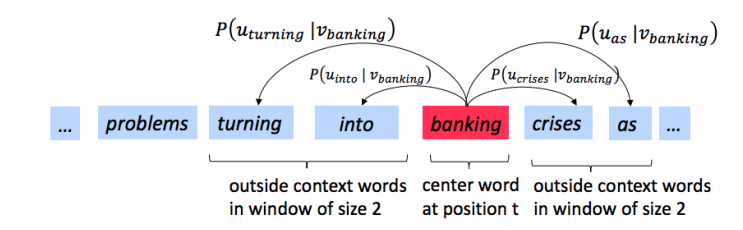

클린업 2주차에서는 Word2Vec 모델로 직접 한국어 임베딩을 생성해보겠습니다.

데이터는 위키피디아 한국어 데이터셋을 사용해볼게요!

이 데이터셋은 1.7GB 크기의 상당히 큰 데이터셋입니다.

위키피디아 데이터셋: https://ko-nlp.github.io/Korpora/en-docs/corpuslist/kowikitext.html

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import os

def my_seed_everywhere(seed: int = 42):
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os

my_seed = 42
my_seed_everywhere(my_seed)

# 데이터셋 다운로드

먼저 데이터 다운로드를 진행해줄게요. 데이터셋은 `Korpora`에서 다운로드 받을 수 있습니다

데이터 다운로드를 위해 중간에 빈칸이 뜨면 'yes'를 타이핑해주시면 됩니다

데이터 다운로드는 대략 1분 정도 걸립니다.

In [3]:
from Korpora import Korpora
corpus = Korpora.load("kowikitext")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : Hyunjoong Kim lovit@github
    Repository : https://github.com/lovit/kowikitext
    References :

    한국어 위키피디아의 덤프 데이터를 바탕을 제작한 wikitext 형식의 텍스트 파일입니다.
    학습 및 평가를 위하여 위키페이지 별로 train (99%), dev (0.5%), test (0.5%) 로 나뉘어져있습니다.


    # License
    CC-BY-SA 3.0 which kowiki dump dataset is licensed

[Korpora] Corpus `kowikitext` is already installed at C:\Users\Junho\Korpora\kowikitext\kowikitext_20200920.train.zip
[Korpora] Corpus `kowikitext` is already installed at C:\Users\Junho\Korpora\kowikitext\kowikitext_20200920.train
[Korpora] Corpus `kowikitext` is already installed at C:\Users\Junho\Korpora\kowikitext\kowikitext_20200920.test.zip
[Korpora] Corpus `kowikitext` is already installed at C:\Users\Junho\Korpora\

데이터 다운로드를 완료했습니다!

# 텍스트 전처리 (~15 mins)

이번에는 텍스트 전처리를 진행해볼게요~

`corpus`는 train, dev, test로 이루어져 있으며, 각각 `.`을 통해 접근할 수 있습니다.

In [4]:
# 구조 확인하기
corpus.train[0]

SentencePair(text='외교부장\n외교부장', pair=' = 분류:중화인민공화국의 외교부장 =')

데이터는 튜플 `SentencePair`로 구성되어 있네요. 여기서 우리가 사용할 것은 train 데이터의 text이므로 분리해줍시다.

In [5]:
train = []

for i in range(len(corpus.train)):
    if i % 100000 == 0:
      print(f"Split {i} 완료!")
    train.append(corpus.train[i].text)

Split 0 완료!
Split 100000 완료!
Split 200000 완료!
Split 300000 완료!
Split 400000 완료!
Split 500000 완료!
Split 600000 완료!
Split 700000 완료!
Split 800000 완료!
Split 900000 완료!
Split 1000000 완료!
Split 1100000 완료!
Split 1200000 완료!
Split 1300000 완료!
Split 1400000 완료!
Split 1500000 완료!
Split 1600000 완료!
Split 1700000 완료!
Split 1800000 완료!
Split 1900000 완료!
Split 2000000 완료!
Split 2100000 완료!
Split 2200000 완료!
Split 2300000 완료!
Split 2400000 완료!
Split 2500000 완료!
Split 2600000 완료!
Split 2700000 완료!
Split 2800000 완료!
Split 2900000 완료!
Split 3000000 완료!
Split 3100000 완료!
Split 3200000 완료!
Split 3300000 완료!
Split 3400000 완료!
Split 3500000 완료!


더 다루기 쉬운 리스트로 옮겨주었습니다.

랜덤하게 데이터 10개만 확인해볼게요

In [6]:
import numpy as np
np.random.seed(42)

idx = np.random.randint(0, len(train), 10)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print()

---------------------- 2219110번째 데이터 ----------------------
전장(mm) : 4,570(1991년~1995년)
전폭(mm) : 1,720(1991년~1995년)
전고(mm) : 1,405
축거(mm) : 2,520
윤거(전, mm) : 1,440
윤거(후, mm) : 1,430
승차정원 : 5명
연료탱크용량(l) : 60
변속기 : 수동 5단/자동 4단
서스펜션(전/후) : 맥퍼슨 스트럿/맥퍼슨 스트럿
제동장치(전/후) : 벤틸레이티드 디스크/드럼
구동형식 : 전륜구동
!구분
!2.0 DOHC
!2.0 SOHC
!1.8 SOHC
!1.8 LPG
!2.0 디젤
!연료
!배기량(cc)
!최고출력(ps/rpm)
!최대토크(kg*m/rpm)
!공차중량(kg)
!연비(km/l)

---------------------- 2768307번째 데이터 ----------------------
IAAF 이진일 프로필

---------------------- 2229084번째 데이터 ----------------------
정화(征和)는 전한(前漢) 무제(武帝)의 열번째 연호이다.
정화(政和)는 북송(北宋) 휘종(徽宗)의 네 번째 연호이다.
쇼와(正和)는 일본의 연호(元号) 중 하나이다.
조와(貞和)는 일본 남북조 시대의 연호(元号) 중 하나이다.

---------------------- 2356330번째 데이터 ----------------------
2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다. 문서 이동을 잘못했는데 복구가 안되는군요. --<span style="color:#191970"><span style="font-size: 13pt; font-family: 'Lucida Handwriting', cursive;">BSİ</span></span> (<span style="color:#008B8B">Talk</span>) 2013년 2월 23일 (토) 14:09 (KST)
:  --Puzzlet

어떻게 전처리를 진행해줘야 할까요? 천천히 생각해보죠

## 1. 줄바꿈 제거

가장 먼저 줄바꿈을 없애주겠습니다. 이스케이프 문자 `\n`을 제거하면 됩니다.

In [7]:
# 줄바꿈 전처리 예시
print("전처리 전: ", train[idx[0]])
print("전처리 후: ", train[idx[0]].replace("\n", ""))

전처리 전:  전장(mm) : 4,570(1991년~1995년)
전폭(mm) : 1,720(1991년~1995년)
전고(mm) : 1,405
축거(mm) : 2,520
윤거(전, mm) : 1,440
윤거(후, mm) : 1,430
승차정원 : 5명
연료탱크용량(l) : 60
변속기 : 수동 5단/자동 4단
서스펜션(전/후) : 맥퍼슨 스트럿/맥퍼슨 스트럿
제동장치(전/후) : 벤틸레이티드 디스크/드럼
구동형식 : 전륜구동
!구분
!2.0 DOHC
!2.0 SOHC
!1.8 SOHC
!1.8 LPG
!2.0 디젤
!연료
!배기량(cc)
!최고출력(ps/rpm)
!최대토크(kg*m/rpm)
!공차중량(kg)
!연비(km/l)
전처리 후:  전장(mm) : 4,570(1991년~1995년)전폭(mm) : 1,720(1991년~1995년)전고(mm) : 1,405축거(mm) : 2,520윤거(전, mm) : 1,440윤거(후, mm) : 1,430승차정원 : 5명연료탱크용량(l) : 60변속기 : 수동 5단/자동 4단서스펜션(전/후) : 맥퍼슨 스트럿/맥퍼슨 스트럿제동장치(전/후) : 벤틸레이티드 디스크/드럼구동형식 : 전륜구동!구분!2.0 DOHC!2.0 SOHC!1.8 SOHC!1.8 LPG!2.0 디젤!연료!배기량(cc)!최고출력(ps/rpm)!최대토크(kg*m/rpm)!공차중량(kg)!연비(km/l)


In [8]:
# 줄바꿈 제거
train = [i.replace("\n", "") for i in train]

np.random.seed(42)

idx = np.random.randint(0, len(train), 10)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print()

---------------------- 2219110번째 데이터 ----------------------
전장(mm) : 4,570(1991년~1995년)전폭(mm) : 1,720(1991년~1995년)전고(mm) : 1,405축거(mm) : 2,520윤거(전, mm) : 1,440윤거(후, mm) : 1,430승차정원 : 5명연료탱크용량(l) : 60변속기 : 수동 5단/자동 4단서스펜션(전/후) : 맥퍼슨 스트럿/맥퍼슨 스트럿제동장치(전/후) : 벤틸레이티드 디스크/드럼구동형식 : 전륜구동!구분!2.0 DOHC!2.0 SOHC!1.8 SOHC!1.8 LPG!2.0 디젤!연료!배기량(cc)!최고출력(ps/rpm)!최대토크(kg*m/rpm)!공차중량(kg)!연비(km/l)

---------------------- 2768307번째 데이터 ----------------------
IAAF 이진일 프로필

---------------------- 2229084번째 데이터 ----------------------
정화(征和)는 전한(前漢) 무제(武帝)의 열번째 연호이다.정화(政和)는 북송(北宋) 휘종(徽宗)의 네 번째 연호이다.쇼와(正和)는 일본의 연호(元号) 중 하나이다.조와(貞和)는 일본 남북조 시대의 연호(元号) 중 하나이다.

---------------------- 2356330번째 데이터 ----------------------
2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다. 문서 이동을 잘못했는데 복구가 안되는군요. --<span style="color:#191970"><span style="font-size: 13pt; font-family: 'Lucida Handwriting', cursive;">BSİ</span></span> (<span style="color:#008B8B">Talk</span>) 2013년 2월 23일 (토) 14:09 (KST):  --Puzzlet Chung (토론) 2013년 2월 23일 (토

줄바꿈이 잘 제거된 것을 볼 수 있습니다.

## 2. html 및 css 태그 제거하기

두 번째로는 html 및 css 태그를 제거해줄게요.

이런 태그는 웹페이지를 꾸미기 위한 태그일 뿐 기사와 관련된 어떠한 의미도 가지고 있지 않습니다.

예를 들어 위의 예시에서 \<span>\<\span> 등의 태그입니다.

In [9]:
# html & css 태그 제거 전처리 예시
import re

print("전처리 전: ", train[idx[3]])
to_clean = re.compile("<.*?>")
print("전처리 후: ", re.sub(to_clean, "", train[idx[3]]))

전처리 전:  2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다. 문서 이동을 잘못했는데 복구가 안되는군요. --<span style="color:#191970"><span style="font-size: 13pt; font-family: 'Lucida Handwriting', cursive;">BSİ</span></span> (<span style="color:#008B8B">Talk</span>) 2013년 2월 23일 (토) 14:09 (KST):  --Puzzlet Chung (토론) 2013년 2월 23일 (토) 15:07 (KST)
전처리 후:  2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다. 문서 이동을 잘못했는데 복구가 안되는군요. --BSİ (Talk) 2013년 2월 23일 (토) 14:09 (KST):  --Puzzlet Chung (토론) 2013년 2월 23일 (토) 15:07 (KST)


In [10]:
# html & css 태그 제거
to_clean = re.compile("<.*?>")
train = [re.sub(to_clean, "", i) for i in train]

np.random.seed(42)

idx = np.random.randint(0, len(train), 10)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print()

---------------------- 2219110번째 데이터 ----------------------
전장(mm) : 4,570(1991년~1995년)전폭(mm) : 1,720(1991년~1995년)전고(mm) : 1,405축거(mm) : 2,520윤거(전, mm) : 1,440윤거(후, mm) : 1,430승차정원 : 5명연료탱크용량(l) : 60변속기 : 수동 5단/자동 4단서스펜션(전/후) : 맥퍼슨 스트럿/맥퍼슨 스트럿제동장치(전/후) : 벤틸레이티드 디스크/드럼구동형식 : 전륜구동!구분!2.0 DOHC!2.0 SOHC!1.8 SOHC!1.8 LPG!2.0 디젤!연료!배기량(cc)!최고출력(ps/rpm)!최대토크(kg*m/rpm)!공차중량(kg)!연비(km/l)

---------------------- 2768307번째 데이터 ----------------------
IAAF 이진일 프로필

---------------------- 2229084번째 데이터 ----------------------
정화(征和)는 전한(前漢) 무제(武帝)의 열번째 연호이다.정화(政和)는 북송(北宋) 휘종(徽宗)의 네 번째 연호이다.쇼와(正和)는 일본의 연호(元号) 중 하나이다.조와(貞和)는 일본 남북조 시대의 연호(元号) 중 하나이다.

---------------------- 2356330번째 데이터 ----------------------
2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다. 문서 이동을 잘못했는데 복구가 안되는군요. --BSİ (Talk) 2013년 2월 23일 (토) 14:09 (KST):  --Puzzlet Chung (토론) 2013년 2월 23일 (토) 15:07 (KST)

---------------------- 1692743번째 데이터 ----------------------
Tomoko Ninomiya's Web : 니노미야 도모코 공식 사이트Kiss on Line : 고단샤 《키스》공식 사이트노다메 왕국 : 

역시나 잘 제거되었네요

## 3. 특수 문자 및 영어 이외의 외국어 문자 제거

세 번째로는 특수 문자와 영어 이외의 외국어 문자들을 제거해줄게요. 이 문자들은 의미 파악에 필요가 없습니다.

아래의 정규식에서 의미하는 바는 다음과 같습니다.

* `\uAC00-\uD7A3` : 모든 한글 음절(가-힣)

* `0-9` : 모든 숫자

* `a-z` : 모든 알파벳 소문자

* `A-Z` : 모든 알파벳 대문자

* `\s` : 공백 이스케이프 문자

이 과정은 대략 40초 정도 걸립니다.

In [11]:
# html & css 태그 제거 전처리 예시
import re

print("전처리 전: ", train[idx[2]])
to_clean = re.compile("[^\uAC00-\uD7A30-9a-zA-Z\s]")
print("전처리 후: ", re.sub(to_clean, "", train[idx[2]]))

전처리 전:  정화(征和)는 전한(前漢) 무제(武帝)의 열번째 연호이다.정화(政和)는 북송(北宋) 휘종(徽宗)의 네 번째 연호이다.쇼와(正和)는 일본의 연호(元号) 중 하나이다.조와(貞和)는 일본 남북조 시대의 연호(元号) 중 하나이다.
전처리 후:  정화는 전한 무제의 열번째 연호이다정화는 북송 휘종의 네 번째 연호이다쇼와는 일본의 연호 중 하나이다조와는 일본 남북조 시대의 연호 중 하나이다


In [12]:
# 특수 문자 및 영어 이외의 외국어 제외
import re

to_clean = re.compile("[^\uAC00-\uD7A30-9a-zA-Z\s]")
train = [re.sub(to_clean, "", i) for i in train]

np.random.seed(42)

idx = np.random.randint(0, len(train), 10)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print

---------------------- 2219110번째 데이터 ----------------------
전장mm  45701991년1995년전폭mm  17201991년1995년전고mm  1405축거mm  2520윤거전 mm  1440윤거후 mm  1430승차정원  5명연료탱크용량l  60변속기  수동 5단자동 4단서스펜션전후  맥퍼슨 스트럿맥퍼슨 스트럿제동장치전후  벤틸레이티드 디스크드럼구동형식  전륜구동구분20 DOHC20 SOHC18 SOHC18 LPG20 디젤연료배기량cc최고출력psrpm최대토크kgmrpm공차중량kg연비kml
---------------------- 2768307번째 데이터 ----------------------
IAAF 이진일 프로필
---------------------- 2229084번째 데이터 ----------------------
정화는 전한 무제의 열번째 연호이다정화는 북송 휘종의 네 번째 연호이다쇼와는 일본의 연호 중 하나이다조와는 일본 남북조 시대의 연호 중 하나이다
---------------------- 2356330번째 데이터 ----------------------
2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다 문서 이동을 잘못했는데 복구가 안되는군요 BS Talk 2013년 2월 23일 토 1409 KST  Puzzlet Chung 토론 2013년 2월 23일 토 1507 KST
---------------------- 1692743번째 데이터 ----------------------
Tomoko Ninomiyas Web  니노미야 도모코 공식 사이트Kiss on Line  고단샤 키스공식 사이트노다메 왕국  고단샤 포털 사이트 MouRa모우라애니메이션 노다메 칸타빌레 공식 사이트노다메 칸타빌레 DS 공식 사이트
---------------------- 110268번째 데이터 ----------------------
2010년 MBC 스타 오디션 위대한 탄생 중국 예선편2011년 12

## 4. 짧은 텍스트 제거

어떤 텍스트들은 너무 짧기 때문에 필요가 없습니다. 어느 정도가 적당할 지, 위의 샘플 텍스트들을 보면서 판단해보겠습니다.

전처리가 꽤 진행되었으니 30개를 보도록 할게요.

In [13]:
np.random.seed(42)

idx = np.random.randint(0, len(train), 30)
for i in idx:
    print(f"---------------------- {i}번째 데이터, 길이 = {len(train[i])} ----------------------")
    print(train[i])
    print()

---------------------- 2219110번째 데이터, 길이 = 241 ----------------------
전장mm  45701991년1995년전폭mm  17201991년1995년전고mm  1405축거mm  2520윤거전 mm  1440윤거후 mm  1430승차정원  5명연료탱크용량l  60변속기  수동 5단자동 4단서스펜션전후  맥퍼슨 스트럿맥퍼슨 스트럿제동장치전후  벤틸레이티드 디스크드럼구동형식  전륜구동구분20 DOHC20 SOHC18 SOHC18 LPG20 디젤연료배기량cc최고출력psrpm최대토크kgmrpm공차중량kg연비kml

---------------------- 2768307번째 데이터, 길이 = 12 ----------------------
IAAF 이진일 프로필

---------------------- 2229084번째 데이터, 길이 = 80 ----------------------
정화는 전한 무제의 열번째 연호이다정화는 북송 휘종의 네 번째 연호이다쇼와는 일본의 연호 중 하나이다조와는 일본 남북조 시대의 연호 중 하나이다

---------------------- 2356330번째 데이터, 길이 = 136 ----------------------
2010년 월드컵 선수 명단 표기를 보니 안드러가 아닌 안드레 였습니다 문서 이동을 잘못했는데 복구가 안되는군요 BS Talk 2013년 2월 23일 토 1409 KST  Puzzlet Chung 토론 2013년 2월 23일 토 1507 KST

---------------------- 1692743번째 데이터, 길이 = 129 ----------------------
Tomoko Ninomiyas Web  니노미야 도모코 공식 사이트Kiss on Line  고단샤 키스공식 사이트노다메 왕국  고단샤 포털 사이트 MouRa모우라애니메이션 노다메 칸타빌레 공식 사이트노다메 칸타빌레 DS 공식 사이트

---------------------- 110268번째 데이터, 길이 = 54

음... 적어도 길이가 50은 되어야 하나의 문장이라고 여길 수 있겠군요.

길이가 50 미만인 텍스트들은 모두 제거해주겠습니다.

In [14]:
# 길이가 50 미만인 텍스트 모두 제거
print("전처리 전: 길이 =", len(train))

for i in range(len(train)):
    if len(train[i]) < 50:
        train[i] = ""

train = [i for i in train if i != ""]

print("전처리 후: 길이 =", len(train))

전처리 전: 길이 = 3510734
전처리 후: 길이 = 1790990


데이터가 대략 절반으로 줄었네요. 랜덤하게 30개의 데이터를 뽑아서 확인해보겠습니다.

In [15]:
np.random.seed(42)

idx = np.random.randint(0, len(train), 30)
for i in idx:
    print(f"---------------------- {i}번째 데이터, 길이 = {len(train[i])} ----------------------")
    print(train[i])
    print()

---------------------- 121958번째 데이터, 길이 = 102 ----------------------
 width7 scopecol  연도 width34 scopecol  작품 width34 scopecol  부문 width9 scopecol  결과 width9 scopecol  출처

---------------------- 671155번째 데이터, 길이 = 110 ----------------------
사우스조지아 사우스샌드위치 제도의 문장은 1985년 영토가 창설되면서 부여되었다 문장은 사우스조지아섬에있는 순록 두 무리의 순록이다 표어는 Leo Terram Propriam Protegat이다국장

---------------------- 131932번째 데이터, 길이 = 55 ----------------------
본점 충청남도 천안시 서북구 직산읍 거리막길 33서울지점 서울특별시 중구 정동길 14 정동 오송빌딩

---------------------- 1414414번째 데이터, 길이 = 432 ----------------------
 앤티가 바부다세인트존스  VC 버드 국제공항 아루바오라녜스타트  퀸 비어트릭스 국제공항 바하마프리포트  그랜드 바하마 국제공항나소  린든 핀들링 국제공항 바베이도스그레이트 레이 아담스 국제공항 케이맨 제도그랜드 케이먼  오웬 로버츠 국제공항 도미니카 공화국푼타카나  푼타카나 국제공항산티아고데로스카바예로스  시바오 국제공항산토도밍고  라스 아메리카 국제공항 자메이카몬티  상스터 국제공항 푸에르토리코산후안  루이스 무노즈 마린 국제공항 세인트키츠네비스세인트 키츠  로버트 L 브래드쇼 국제공항 세인트루시아뷰포트  하와노리아 국제공항 신트마르턴신트마르턴  프린세스 줄리아나 국제공항 터크스 케이커스 제도프로비던셜스  프로비던셜스 국제공항 터크스 케이커스 제도프로비던셜스  프로비던셜스 국제공항 버진 아일랜드세인트 토마스  시릴 E 킹 공항세인트 크로  헨리 E 로이슨 공항

-----------------

## 5. 한국어 데이터 포함 비율

아직 전처리가 조금 부족한 것 같습니다. 한국어 데이터셋을 학습시켜야 하지만 온전한 영어 문장도 있기 때문이죠.

따라서 아래의 언어 탐지 함수가 한국어라고 판단한 데이터들만 남겨주겠습니다.

In [16]:
# 영어 알파벳 모으기
import string

en = []
lower = string.ascii_lowercase
lower = [lower[i:i+1] for i in range(len(lower))]

upper = string.ascii_uppercase
upper = [upper[i:i+1] for i in range(len(upper))]

en = lower + upper
print(en)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [17]:
# 한국어 포함 비율 판단 함수
def ko_prob(text):
    en_count = sum(1 for char in text if char in en)
    return 1 - (en_count / len(text))

In [18]:
# 한국어 포함 비율 판단 예시
np.random.seed(42)

idx = np.random.randint(0, len(train), 30)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print(f"한국어 포함 비율: {ko_prob(train[i]):.2f}")
    print()

---------------------- 121958번째 데이터 ----------------------
 width7 scopecol  연도 width34 scopecol  작품 width34 scopecol  부문 width9 scopecol  결과 width9 scopecol  출처
한국어 포함 비율: 0.36

---------------------- 671155번째 데이터 ----------------------
사우스조지아 사우스샌드위치 제도의 문장은 1985년 영토가 창설되면서 부여되었다 문장은 사우스조지아섬에있는 순록 두 무리의 순록이다 표어는 Leo Terram Propriam Protegat이다국장
한국어 포함 비율: 0.77

---------------------- 131932번째 데이터 ----------------------
본점 충청남도 천안시 서북구 직산읍 거리막길 33서울지점 서울특별시 중구 정동길 14 정동 오송빌딩
한국어 포함 비율: 1.00

---------------------- 1414414번째 데이터 ----------------------
 앤티가 바부다세인트존스  VC 버드 국제공항 아루바오라녜스타트  퀸 비어트릭스 국제공항 바하마프리포트  그랜드 바하마 국제공항나소  린든 핀들링 국제공항 바베이도스그레이트 레이 아담스 국제공항 케이맨 제도그랜드 케이먼  오웬 로버츠 국제공항 도미니카 공화국푼타카나  푼타카나 국제공항산티아고데로스카바예로스  시바오 국제공항산토도밍고  라스 아메리카 국제공항 자메이카몬티  상스터 국제공항 푸에르토리코산후안  루이스 무노즈 마린 국제공항 세인트키츠네비스세인트 키츠  로버트 L 브래드쇼 국제공항 세인트루시아뷰포트  하와노리아 국제공항 신트마르턴신트마르턴  프린세스 줄리아나 국제공항 터크스 케이커스 제도프로비던셜스  프로비던셜스 국제공항 터크스 케이커스 제도프로비던셜스  프로비던셜스 국제공항 버진 아일랜드세인트 토마스  시릴 E 킹 공항세인트 크로  헨리 E 로이슨 공항
한국어 포함 비율

In [19]:
# 일부 데이터 전처리(5만 개)에 대한 시간 측정
import time

np.random.seed(42)

start = time.time()
idx = np.random.randint(0, len(train), 50000)
for i in idx:
  ko_prob(train[i])

end = time.time()
print(f"걸린 시간: {end - start:.4f}초")

걸린 시간: 7.7792초


이 전처리 과정은 **5~10분** 정도 소요됩니다.

In [20]:
# 한국어 포함 비율이 낮은 데이터 제거
print("전처리 전: 길이 =", len(train))

start = time.time()
for i in range(len(train)):
    prob = ko_prob(train[i])
    if prob < 0.7:
        train[i] = ""

train = [i for i in train if i != ""]

end = time.time()
print(f"걸린 시간: {end - start:.4f}초")
print("전처리 후: 길이 =", len(train))

전처리 전: 길이 = 1790990
걸린 시간: 314.5338초
전처리 후: 길이 = 1563464


최종 데이터를 보도록 할까요? 마찬가지로 30개의 데이터를 샘플링하겠습니다.

In [24]:
# 최종 전처리 데이터 샘플링
np.random.seed(42)

idx = np.random.randint(0, len(train), 30)
for i in idx:
    print(f"---------------------- {i}번째 데이터 ----------------------")
    print(train[i])
    print()

---------------------- 121958번째 데이터 ----------------------
2000년 11월 22일경 김옥경은 조부이자 애국지사인 김용원의 유적비 건립 현황을 확인하기 위해서 은평공원대전광역시 서구 월평동을 찾았다 그러나 비문 정면에 새겨진 생애비높이 14m 폭 18m와 휘호비높이 43m 폭 14m에는 김씨의 조부가 아닌 이돈직이라는 알 수 없는 사람의 휘호와 공적이 새겨져 있었다 현장에는 김용원의 흉상이 없었고 정작 김씨 조부의 생애와 휘호는 각각 뒷면에 새겨져 있었음이 드러났다 조사를 해보니 은평공원 휘호비생애비와 원정동 김용원 선생 공적비 효평동 이돈직 공적비 대덕구 비래동산무궁화동산 비문에도 이인구의 조부 이돈직의 부풀려진 공적이 적혀있는 것으로 확인됐다는 2003년 12월 독립투사의 공적비가 변조된 사연을 보도했다 보도에서 대전지역 대표적 독립운동가 중 한 명으로 꼽히는 김용원 선생의 독립운동 행적에 무명의 이돈직 끼워넣기로 독립운동가를 만들려는 첫 시도라고 고발했다대전애국지사숭모회 등이 대전지역 곳곳에 세운 이인구 계룡건설 명예회장의 조부인 고 이돈직 비문에 새겨진 항일운동 행적과 애국지사 김용원 선생과 함께 독립운동을 했다는 비문 등은 확인되지 않았고 무리하게 끼워넣어진 것이라고 내용이다 특히 대전시로부터 지원을 받아 은평공원월평공원에 세워진 이돈직 생애비와 휘호비는 당초 사업 목적에도 맞지 않는데다 휘호비의 경우 불법 조형물로 확인됐다고 지적했다이에 대해 이 명예회장 등은 지난 2004년 4월 와 MBC를 상대로 모두 16억원 6억원 2심에서는 12억원 3억원의 손해배상을 청구하는 소송을 제기했다 그러나 법원은 이인구 계룡건설산업 명예회장 조부의 항일운동 행적은 확인되지 않은 것이라는  보도에 대해 허위 내용으로 볼 수 없다고 판단했다2006년 10월 대전고등법원 제 2민사부는 계룡건설 이인구 명예회장 등이 조부의 반일 항일투쟁 경력을 조작한 것처럼 허위사실을 보도해 명예를 훼손하고 계룡건설과 의 사회적 가치를 저하

이 정도면 전처리가 잘 진행된 것 같습니다!

# 토큰화 (~50 mins)

다음 단계는 토큰화입니다. 토큰화를 위한 다양한 패키지들이 있습니다.

여기서는 `konlpy`, `nltk`, `spaCy` 중 고민해보겠습니다.

세 패키지 모두 자연어처리를 위한 패키지입니다.

`바른`으로 토큰화하는 경우, 가장 좋은 성능을 보이지만 설정 과정이 복잡할 수 있으므로 생략하겠습니다.

In [21]:
# spacy를 위한 모듈 불러오기
!python -m spacy download ko_core_news_sm

     ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
     --------------------------------------- 0.0/14.7 MB 330.3 kB/s eta 0:00:45
     ---------------------------------------- 0.2/14.7 MB 1.8 MB/s eta 0:00:08
     - -------------------------------------- 0.7/14.7 MB 5.2 MB/s eta 0:00:03
     ---- ----------------------------------- 1.5/14.7 MB 8.6 MB/s eta 0:00:02
     ------ --------------------------------- 2.6/14.7 MB 11.6 MB/s eta 0:00:02
     ----------- ---------------------------- 4.2/14.7 MB 15.8 MB/s eta 0:00:01
     ---------------- ----------------------- 6.1/14.7 MB 19.5 MB/s eta 0:00:01
     ---------------------- ----------------- 8.2/14.7 MB 22.9 MB/s eta 0:00:01
     ---------------------------- ---------- 10.6/14.7 MB 32.8 MB/s eta 0:00:01
     ---------------------------------- ---- 13.0/14.7 MB 43.7 MB/s eta 0:00:01
     --------------------------------------  14.7/14.7 MB 50.1 MB/s eta 0:00:01
     --------------------------------------- 14.7/1

In [22]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Junho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
# 토큰화 예시 비교
from konlpy.tag import Okt
from konlpy.tag import Kkma
from nltk import word_tokenize
import spacy
import time

okt = Okt()
kkma = Kkma()
nlp = spacy.load("ko_core_news_sm")

In [24]:
s1 = time.time()
print(okt.morphs(train[0]))
e1 = time.time()
print(f"okt: {e1 - s1:.4f}초")

s1 = time.time()
print(kkma.morphs(train[0]))
e1 = time.time()
print(f"kkma: {e1 - s1:.4f}초")

s1 = time.time()
print(word_tokenize(train[0]))
e1 = time.time()
print(f"word_tokenize: {e1 - s1:.4f}초")

s1 = time.time()
doc = nlp(train[0])
print([token.text for token in doc])
e1 = time.time()
print(f"spacy: {e1 - s1:.4f}초")

['1931년', '서울시', '에서', '태어나', '경기', '중학교', '1982년', '4월', '12일', '자', '매일경제', '서울', '고등학교', '1981년', '4월', '25일', '자', '동아일보', '1956년', '서울대학교', '법학', '과를', '나온', '후', '1956년', '제', '8회', '고등고시', '사법', '과', '에서', '합격', '하였다', '1958년', '서울', '지방검찰청', '검사', '에', '임용', '되었다', '김세', '권', '은', '두산', '그룹', '창업', '주인', '박두병', '딸', '인', '박', '용언', '과', '결혼', '했다', '김세', '권', '과', '박', '용언', '은', '아들', '은', '1970년', '대', '봉제', '업', '으로', '성장한', '태흥', '의', '창업', '주', '권태', '흥', '의', '딸', '권', '혜경', '과', '결혼', '한', '김형일', '일', '경', '산업', '개발', '부회장', '으로', '1990년', '대', '초반', '대한민국', '에', '게스', '폴로', '등', '을', '수입', '해', '유명', '세', '를', '탔던', '기업가', '다', '딸', '김희정', '의', '남편', '은', '최원', '현', '케이', '씨엘', '대표', '변호사', '다', '박승직', '박두병', '박용곤', '박정원', '재벌', '가', '4', '대', '33', '명', '결혼', '스토리', '대검찰청', '차장', '으로', '재직', '하던', '1986년', '2월', '전국', '검사', '장', '회의', '를', '주재', '하면서', '국법', '질서', '확립', '을', '위', '한', '검찰', '의', '과제', '라는', '주제', '로', '토의', '를', '하여', '국법', '질서', '와', '사회', '기강', '확립',

토큰화 예시에서 OKT가 시간 대비 제일 괜찮은 결과를 주는 것 같습니다.

따라서 OKT로 토큰화 해줄게요

**이 작업은 상당히 오래 걸리는 작업입니다 (20만개 기준 약 40분 소요)**

rand_idx 부분의 코드에서 원하는 데이터만큼 변경해주면 됩니다.

In [25]:
import numpy as np

tokens = []

np.random.seed(42)

rand_idx = np.random.randint(0, len(train), 200000)

start = time.time()

for i, idx in enumerate(rand_idx):
    if i % 1000 == 0:
        print(f"{i}번째 데이터 처리 중...")
        t1 = time.time()
        print(f"걸린 시간: {t1 - start:.2f}초")
    tokens.append(okt.morphs(train[idx]))

end = time.time()
print(f"걸린 시간: {end - start:.2f}초")

0번째 데이터 처리 중...
걸린 시간: 0.00초
1000번째 데이터 처리 중...
걸린 시간: 8.23초
2000번째 데이터 처리 중...
걸린 시간: 16.75초
3000번째 데이터 처리 중...
걸린 시간: 25.47초
4000번째 데이터 처리 중...
걸린 시간: 33.78초
5000번째 데이터 처리 중...
걸린 시간: 42.13초
6000번째 데이터 처리 중...
걸린 시간: 49.74초
7000번째 데이터 처리 중...
걸린 시간: 57.60초
8000번째 데이터 처리 중...
걸린 시간: 67.25초
9000번째 데이터 처리 중...
걸린 시간: 75.11초
10000번째 데이터 처리 중...
걸린 시간: 84.26초
11000번째 데이터 처리 중...
걸린 시간: 92.45초
12000번째 데이터 처리 중...
걸린 시간: 100.51초
13000번째 데이터 처리 중...
걸린 시간: 107.80초
14000번째 데이터 처리 중...
걸린 시간: 115.54초
15000번째 데이터 처리 중...
걸린 시간: 122.74초
16000번째 데이터 처리 중...
걸린 시간: 129.97초
17000번째 데이터 처리 중...
걸린 시간: 137.40초
18000번째 데이터 처리 중...
걸린 시간: 145.27초
19000번째 데이터 처리 중...
걸린 시간: 154.98초
20000번째 데이터 처리 중...
걸린 시간: 163.73초
21000번째 데이터 처리 중...
걸린 시간: 171.31초
22000번째 데이터 처리 중...
걸린 시간: 179.98초
23000번째 데이터 처리 중...
걸린 시간: 188.61초
24000번째 데이터 처리 중...
걸린 시간: 197.66초
25000번째 데이터 처리 중...
걸린 시간: 214.03초
26000번째 데이터 처리 중...
걸린 시간: 222.74초
27000번째 데이터 처리 중...
걸린 시간: 230.69초
28000번째 데이터 처리 중...
걸린 시간: 240.01초
29000번째 데이터 

In [ ]:
# import numpy as np

# tokens = []

# np.random.seed(42)

# start = time.time()

# for i in range(500000):
#     if i % 10000 == 0:
#         print(f"{i}번째 데이터 처리 중...")
#         t1 = time.time()
#         print(f"걸린 시간: {t1 - start:.2f}초")
#     tokens.append(okt.morphs(train[i]))

# end = time.time()
# print(f"걸린 시간: {end - start:.2f}초")

In [26]:
total_tokens = sum(len(token) for token in tokens)
print(f"토큰의 총 개수: {total_tokens}")

토큰의 총 개수: 27041920


저희가 학습할 총 토큰 수는 약 2700만 개이네요!

# Word2Vec 학습하기 (~20 mins)

토큰화까지 완료되었기 때문에 Word2Vec 모델을 학습시켜볼게요!

`gensim` 패키지에서 불러올 수 있습니다.

모델 파라미터는 아래와 같이 설정해주었습니다.

이 외에도 다양한 파라미터가 존재합니다. 이는 아래의 사이트를 참고해주세요

Word2Vec: https://radimrehurek.com/gensim/models/word2vec.html

* `sentences` = `tokens` - 학습할 데이터

* `vector_size` = `128` - 임베딩 벡터의 차원

* `window` = `5` - 좌우 context 사이즈

* `min_count` = `3` - Embedding에 추가할 때 필요한 단어 최소 등장 빈도

* `sg` = `1` - {0, 1}의 값. 0이면 CBOW로 학습

* `negative` = `5` - Negative Sampling할 노이즈 데이터 수


## 모델 구성하기

In [27]:
from gensim.models import Word2Vec

# 모델 구성하기
model = Word2Vec(vector_size=128, window=5, min_count=3,
                 sg=1, negative=5)

먼저 첫 번째로 Word2Vec 임베딩을 만들기 위해서는 `build_vocab` 메서드로

단어 집합을 만들어줘야합니다. 아래와 같이 만들어줄 수 있습니다.

## 단어 집합 만들기

In [28]:
# 단어 집합 만들기
t = time.time()

model.build_vocab(tokens, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.12 mins


단어 집합의 크기를 확인해볼게요!

In [29]:
print(f"단어 집합 크기 확인: {model.wv.vectors.shape}")

단어 집합 크기 확인: (200523, 128)


`200523 X 128`의 임베딩 행렬이 만들어졌군요!

하지만 이 임베딩 행렬은 단지 초기값일 뿐입니다. 즉, 학습이 필요하다는 말이죠.

## Embedding 만들기

이제 임베딩을 학습해줄게요. 이 작업은 약 **10~15분** 정도 걸릴 수 있습니다.

In [30]:
t = time.time()

model.train(tokens, total_examples=model.corpus_count, epochs=10)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 11.48 mins


## Embedding 확인하기

이제 만든 임베딩을 확인해볼까요?

학습된 임베딩은 `model.wv`에 저장되어 있습니다.

이 인스턴스는 KeyedVectors로,  접근할 수 있습니다.

### 유사도 분석

In [31]:
# KeyedVectors 할당하기
word_vectors = model.wv

먼저 양의 관계에 있는 단어를 알아보겠습니다.

In [32]:
# 긍정적인 단어 및 유사도 출력 (1)
word_vectors.most_similar(positive=["컴퓨터"])

[('하드웨어', 0.7588070631027222),
 ('소프트웨어', 0.7550681233406067),
 ('VAX', 0.7519944906234741),
 ('마이크로컴퓨터', 0.7400373816490173),
 ('CAD', 0.7320318222045898),
 ('IIGS', 0.7269949316978455),
 ('시분할', 0.7160534858703613),
 ('랩톱', 0.7152823805809021),
 ('Sprite', 0.7152731418609619),
 ('PVM', 0.7141070365905762)]

In [33]:
# 긍정적인 단어 및 유사도 출력 (2)
word_vectors.most_similar(positive=["파이썬"])

[('자이썬', 0.8166624307632446),
 ('스몰토크', 0.8069655299186707),
 ('스크립팅', 0.7988269925117493),
 ('포트란', 0.7984868884086609),
 ('인터프리터', 0.797805905342102),
 ('런타임', 0.7949533462524414),
 ('Qt', 0.7938246130943298),
 ('wxWidgets', 0.7935881018638611),
 ('어셈블리어', 0.7932769060134888),
 ('액션스크립트', 0.7899165153503418)]

In [34]:
# 긍정적인 단어 및 유사도 출력 (3)
word_vectors.most_similar(positive=["남자"])

[('여자', 0.820977509021759),
 ('마루운동', 0.6516976952552795),
 ('트램폴린', 0.6494662761688232),
 ('슈퍼헤비급', 0.633794903755188),
 ('슬라럼', 0.6256519556045532),
 ('EABA', 0.6239640116691589),
 ('장애물경주', 0.6229270100593567),
 ('로맨틱코미디', 0.6201909780502319),
 ('차서울', 0.6168308258056641),
 ('miyandau', 0.6140758991241455)]

단어 사이의 관계 또한 모델이 파악할 수 있을까요?

In [35]:
# 단어 사이의 관계 (1)
word_vectors.most_similar(positive=["이탈리아", "요리"], topn=5)

[('아오스타', 0.711064338684082),
 ('폴렌타', 0.7022109627723694),
 ('코테키노', 0.6940657496452332),
 ('마르살라', 0.6791427731513977),
 ('피에몬테', 0.6693055629730225)]

In [36]:
# 단어 사이의 관계 (1)
word_vectors.most_similar(positive=["한국", "요리"], topn=5)

[('후리카케', 0.6655272841453552),
 ('20100623', 0.6623979806900024),
 ('자폰', 0.6530624628067017),
 ('화과자', 0.65095055103302),
 ('음식', 0.6428438425064087)]

음.. 확실히 학습이 덜 되었기 때문에 결과가 잘 안 나오기도 하는군요

이 문제는 부족한 데이터를 더 학습하면 완화될 것입니다.

그 다음으로 단어 간의 의미를 분석하는 일을 해보겠습니다.

예를 들어, `사람`과 `나이`에 대한 임베딩이 주어지고, 여기서 `노인`의 임베딩을 빼면 어떤 결과가 나올까요?

과연 모델은 이들 사이의 관계를 파악할 수 있을까요?

In [40]:
# 단어 간 의미 분석 (1)
word_vectors.most_similar(positive=["사람", "나이"], negative=["노인"], topn=5)

[('살의', 0.5787782073020935),
 ('이루어질수', 0.551463782787323),
 ('높임말', 0.5246351361274719),
 ('부르겠다고', 0.5226143598556519),
 ('햇수', 0.5183002948760986)]

In [46]:
# 단어 간 의미 분석 (2)
word_vectors.most_similar(positive=["달", "목성"], negative=["지구"], topn=5)

[('질량', 0.5193728804588318),
 ('104일', 0.48612725734710693),
 ('시직경', 0.481829971075058),
 ('273일', 0.48083242774009705),
 ('천왕성', 0.48079437017440796)]

In [47]:
# 단어 간 의미 분석 (3)
word_vectors.most_similar(positive=["노동", "구조"], negative=["사장"], topn=5)

[('불안정하고', 0.5937744379043579),
 ('mita', 0.5789293646812439),
 ('하부구조', 0.5718237161636353),
 ('Structural', 0.5711135268211365),
 ('Federalism', 0.5646846890449524)]

### 임베딩 시각화

마지막으로 임베딩을 시각화해보도록 하겠습니다. 2차원 시각화를 위해서 PCA로 차원 축소해줄게요!

그리고 너무 많은 단어가 있기 때문에, 30개만 샘플링할게요.

In [48]:
from sklearn.decomposition import PCA

np.random.seed(42)

rand_idx = np.random.randint(0, word_vectors.vectors.shape[0], 30)

vocabs = []
for idx in rand_idx:
    vocabs.append(word_vectors.index_to_key[idx])
word_vectors_list = [word_vectors[v] for v in vocabs]

pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)

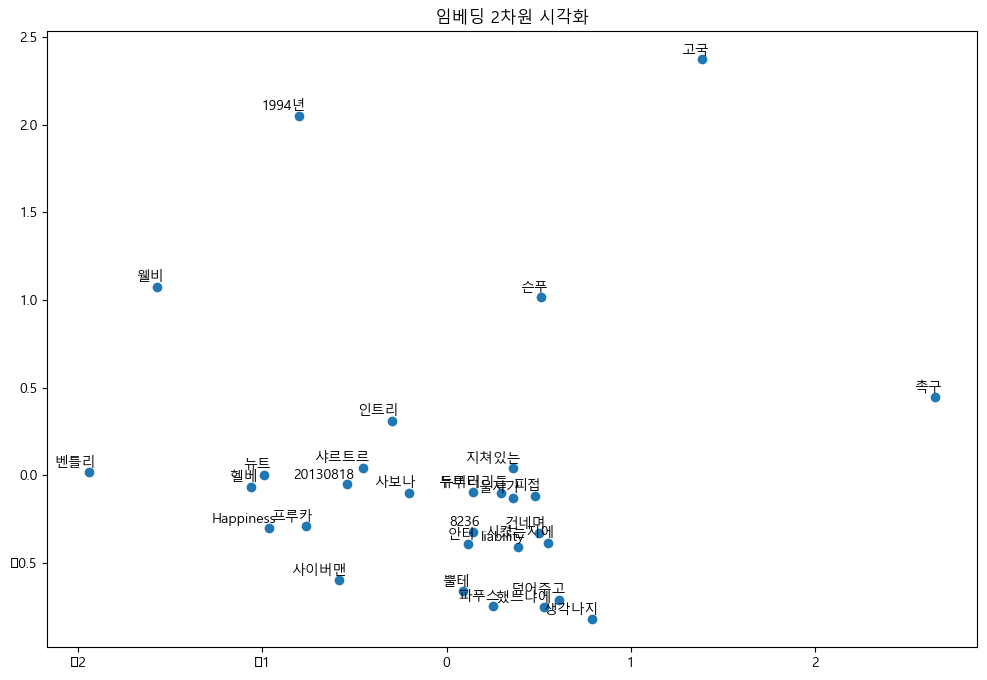

In [49]:
import matplotlib.pyplot as plt

xs = xys[:, 0]
ys = xys[:, 1]

# 한글 폰트를 위함 (만약 맑은고딕이 없으면 다운로드 후 이용할 수 있습니다)
plt.rc('font', family='Malgun Gothic')

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys)
for x, y, vocab in zip(xs, ys, vocabs):
    plt.annotate(vocab, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.title('임베딩 2차원 시각화')
plt.show()

이렇게 실습을 마치도록 하겠습니다!